In [20]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [21]:
# Paths for data.
Ravdess = r"Audio"
Crema = r"AudioWAV"
Tess = r"TESS Toronto emotional speech set data"
Savee = r"ALL"

In [22]:
# Listing the files in the Ravdess directory
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

# Iterating through each directory (actor)
for dir in ravdess_directory_list:
    actor_dir = os.path.join(Ravdess, dir)  # Use os.path.join for path concatenation
    if os.path.isdir(actor_dir):  # Ensure it is a directory
        actor = os.listdir(actor_dir)  # Listing files for each actor
        for file in actor:
            part = file.split('.')[0]  # Extracting the file name without the extension
            part = part.split('-')
            # Extracting the emotion from the third part of the file name
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(actor_dir, file))  # Use os.path.join for the file path

# Creating a DataFrame for the emotions of the files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Creating a DataFrame for the paths of the files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenating the two DataFrames along the columns
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Replacing the integer codes with actual emotion names
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 
                             6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)

# Displaying the first few rows of the final DataFrame
Ravdess_df.head()


Emotions                                     Path
0  neutral  Audio\Actor_01\03-01-01-01-01-01-01.wav
1  neutral  Audio\Actor_01\03-01-01-01-01-02-01.wav
2  neutral  Audio\Actor_01\03-01-01-01-02-01-01.wav
3  neutral  Audio\Actor_01\03-01-01-01-02-02-01.wav
4     calm  Audio\Actor_01\03-01-02-01-01-01-01.wav

In [23]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                         Path
0    angry  AudioWAV1001_DFA_ANG_XX.wav
1  disgust  AudioWAV1001_DFA_DIS_XX.wav
2     fear  AudioWAV1001_DFA_FEA_XX.wav
3    happy  AudioWAV1001_DFA_HAP_XX.wav
4  neutral  AudioWAV1001_DFA_NEU_XX.wav

In [24]:
# Listing the files in the Tess directory
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

# Iterating through each directory in the Tess folder
for dir in tess_directory_list:
    dir_path = os.path.join(Tess, dir)  # Use os.path.join for path concatenation
    if os.path.isdir(dir_path):  # Ensure it's a directory
        directories = os.listdir(dir_path)  # Listing files for each subdirectory
        for file in directories:
            part = file.split('.')[0]  # Extracting the file name without the extension
            part_split = part.split('_')  # Splitting by underscore

            # Check if the filename has at least 3 parts after splitting by '_'
            if len(part_split) >= 3:
                emotion_part = part_split[2]  # Extracting the emotion part
                # Mapping 'ps' to 'surprise' emotion, else appending the part directly
                if emotion_part == 'ps':
                    file_emotion.append('surprise')
                else:
                    file_emotion.append(emotion_part)
            else:
                # If the filename doesn't have enough parts, append 'unknown' or handle it accordingly
                file_emotion.append('unknown')
            
            file_path.append(os.path.join(dir_path, file))  # Use os.path.join for the full path

# Creating a DataFrame for the emotions of the files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Creating a DataFrame for the paths of the files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenating the two DataFrames along the columns
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Displaying the first few rows of the final DataFrame
Tess_df.head()


Emotions                                               Path
0    angry  TESS Toronto emotional speech set data\OAF_ang...
1    angry  TESS Toronto emotional speech set data\OAF_ang...
2    angry  TESS Toronto emotional speech set data\OAF_ang...
3    angry  TESS Toronto emotional speech set data\OAF_ang...
4    angry  TESS Toronto emotional speech set data\OAF_ang...

In [25]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions           Path
0    angry  ALLDC_a01.wav
1    angry  ALLDC_a02.wav
2    angry  ALLDC_a03.wav
3    angry  ALLDC_a04.wav
4    angry  ALLDC_a05.wav

In [26]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                     Path
0  neutral  Audio\Actor_01\03-01-01-01-01-01-01.wav
1  neutral  Audio\Actor_01\03-01-01-01-01-02-01.wav
2  neutral  Audio\Actor_01\03-01-01-01-02-01-01.wav
3  neutral  Audio\Actor_01\03-01-01-01-02-02-01.wav
4     calm  Audio\Actor_01\03-01-02-01-01-01-01.wav

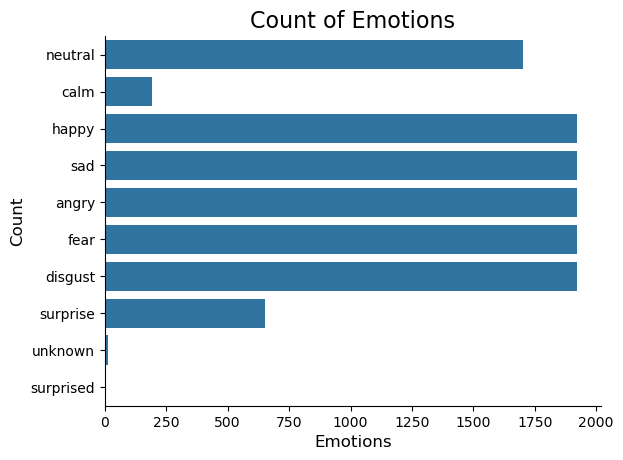

In [27]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [28]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

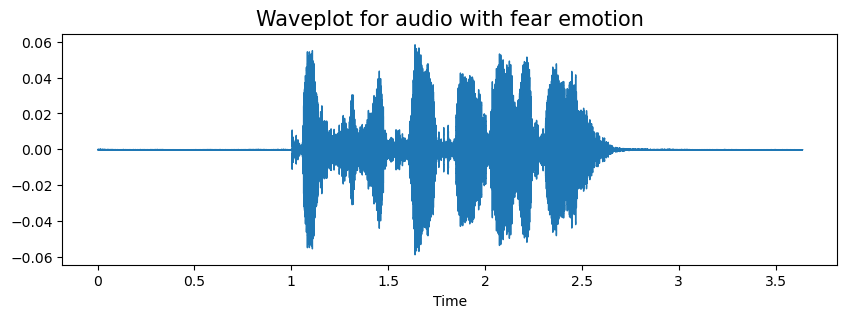

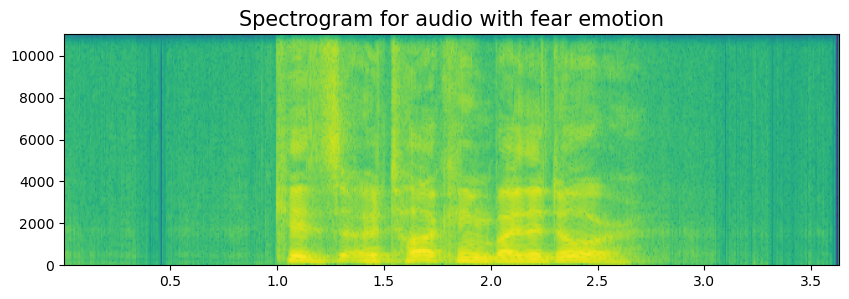

In [29]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define emotion and get the corresponding path
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Function to create waveplot
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)  # Use waveshow instead of waveplot
    plt.show()

# Function to create spectrogram
def create_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.specgram(data, Fs=sr)
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    plt.show()

# Create waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio file
Audio(path)


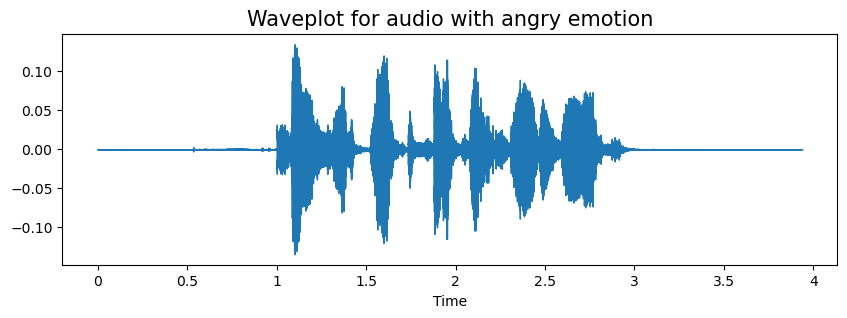

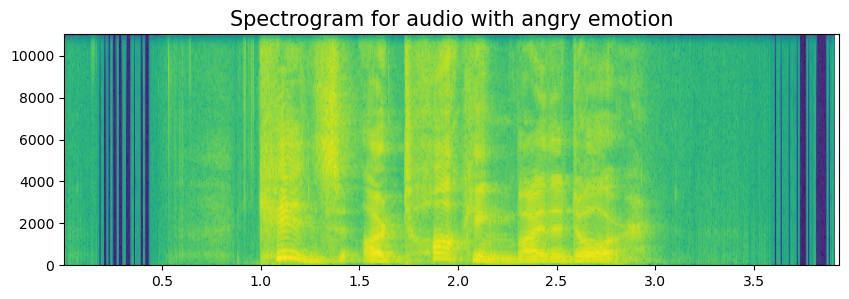

In [30]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define emotion and get the corresponding path
emotion = 'angry'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Function to create waveplot
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)  # Use waveshow instead of waveplot
    plt.show()

# Function to create spectrogram
def create_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.specgram(data, Fs=sr)
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    plt.show()

# Create waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio file
Audio(path)


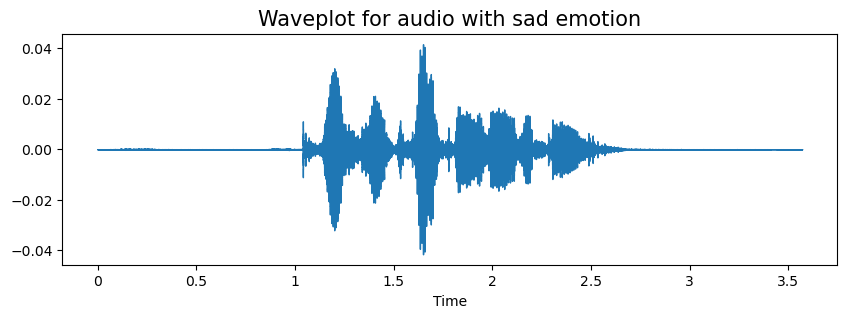

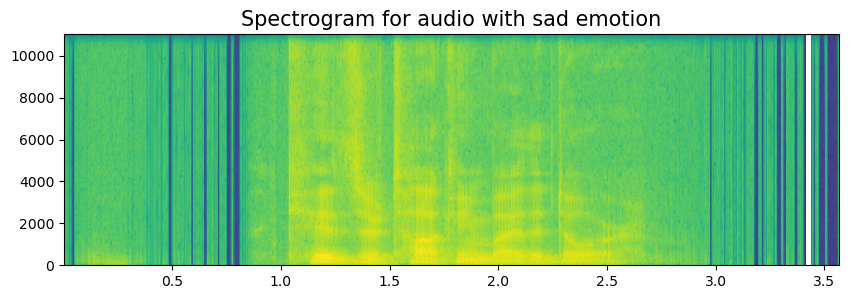

In [31]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define emotion and get the corresponding path
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Function to create waveplot
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)  # Use waveshow instead of waveplot
    plt.show()

# Function to create spectrogram
def create_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.specgram(data, Fs=sr)
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    plt.show()

# Create waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio file
Audio(path)


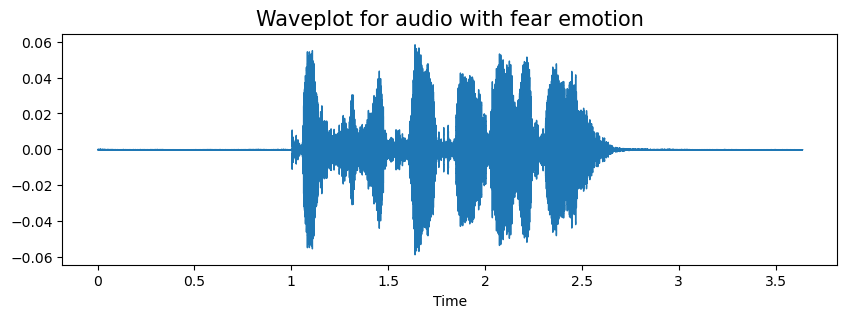

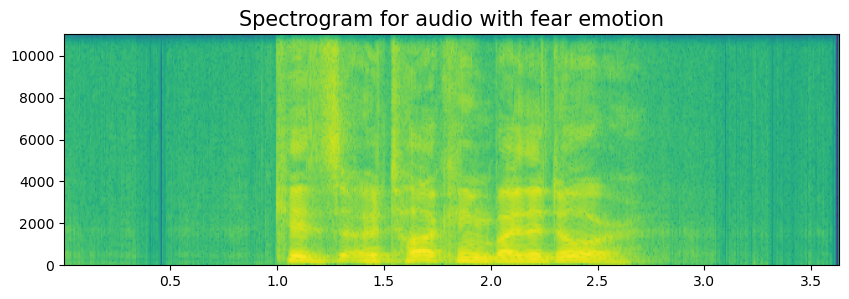

In [32]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define emotion and get the corresponding path
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Function to create waveplot
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)  # Use waveshow instead of waveplot
    plt.show()

# Function to create spectrogram
def create_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.specgram(data, Fs=sr)
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    plt.show()

# Create waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio file
Audio(path)


In [33]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

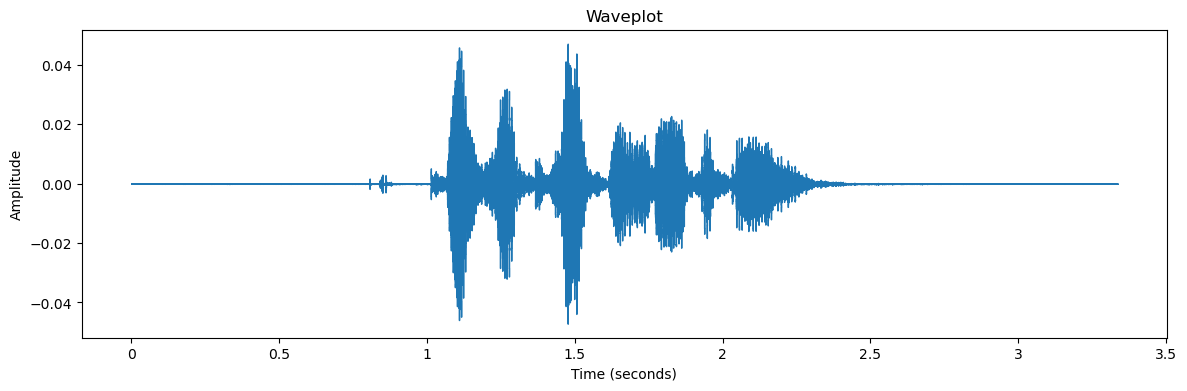

In [34]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveplot using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data, sr=sample_rate)  # Use waveshow instead of waveplot
plt.title('Waveplot')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio file
Audio(path)


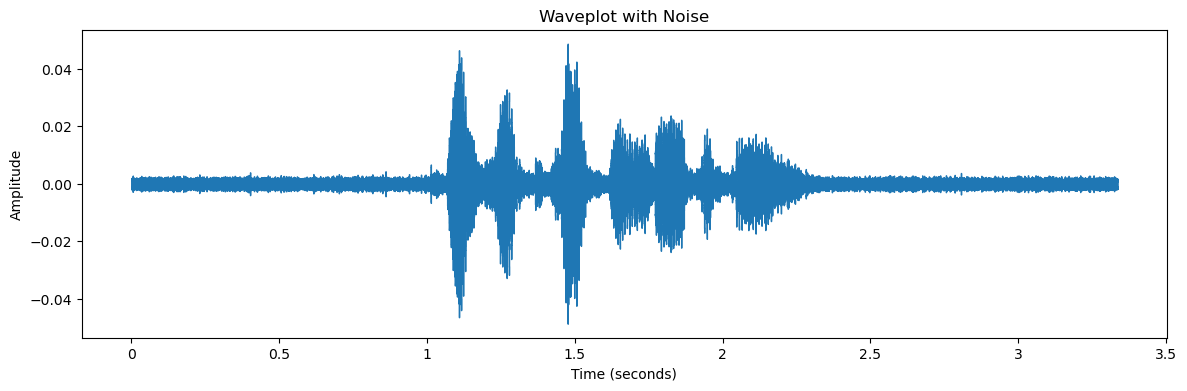

In [35]:
x = noise(data)

# Plot the waveplot using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)  # Use waveshow instead of waveplot
plt.title('Waveplot with Noise')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio data with noise
Audio(x, rate=sample_rate)


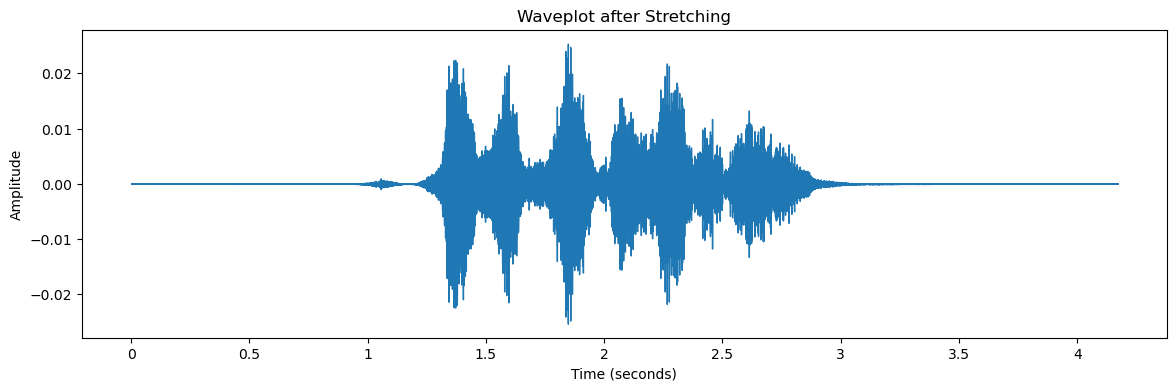

In [36]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define the stretch function
def stretch(data, rate=0.8):
    # Apply time stretching to the audio signal
    return librosa.effects.time_stretch(data, rate=rate)  # Use 'rate=rate' to avoid the TypeError

# Load the audio file
# Ensure 'data' is your audio data, replace with your actual audio loading code if needed
# data, sample_rate = librosa.load(your_audio_path)

# Example audio data for demonstration (you can load your own audio file here)
# data = np.random.randn(22050)  # Example: 1 second of random noise
# sample_rate = 22050  # Example: typical sampling rate

# Use the function
x = stretch(data, rate=0.8)  # Use the stretch function correctly

# Plot the waveplot using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)  # Use waveshow instead of waveplot
plt.title('Waveplot after Stretching')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

# Play the stretched audio data
Audio(x, rate=sample_rate)


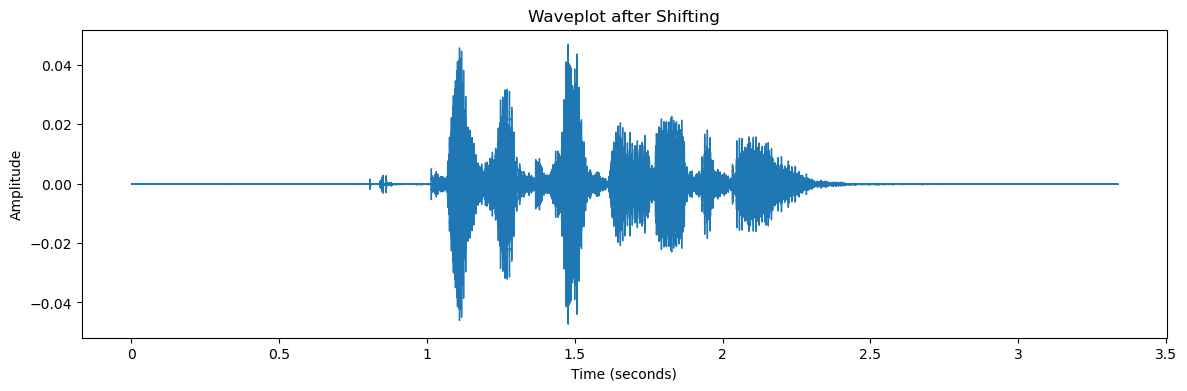

In [37]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define the shift function
def shift(data, shift_value=1):
    # Shift the audio signal by a certain number of samples
    return np.roll(data, shift_value)

# Load the audio file
# Ensure 'data' is your audio data, replace with your actual audio loading code if needed
# data, sample_rate = librosa.load(your_audio_path)

# Example audio data for demonstration (you can load your own audio file here)
# data = np.random.randn(22050)  # Example: 1 second of random noise
# sample_rate = 22050  # Example: typical sampling rate

# Use the function
x = shift(data, shift_value=1)  # Use the shift function correctly

# Plot the waveplot using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)  # Use waveshow instead of waveplot
plt.title('Waveplot after Shifting')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

# Play the shifted audio data
Audio(x, rate=sample_rate)


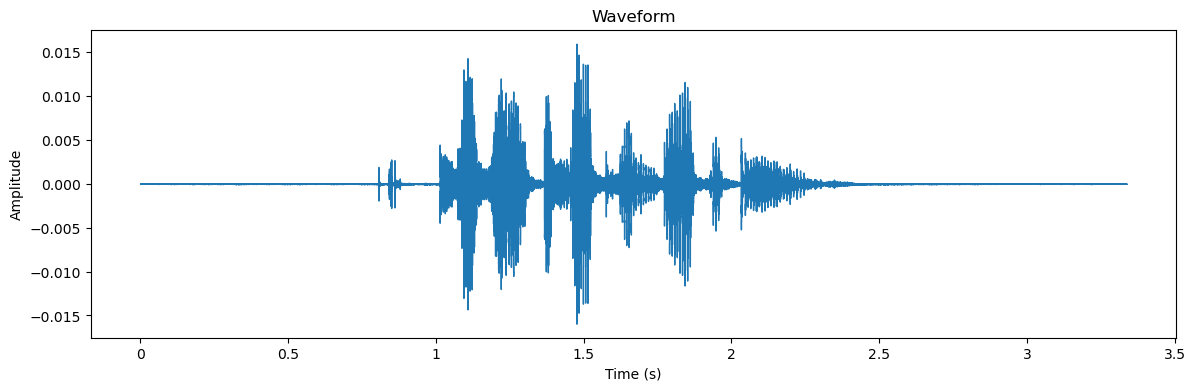

In [38]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Load your audio file (assuming `data` is your audio time series)
# For example:
# data, sample_rate = librosa.load('your_audio_file.wav')

# Shift your audio data
x = librosa.effects.preemphasis(data)

# Plot the waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)  # Use waveshow instead of waveplot in recent versions
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
Audio(x, rate=sample_rate)


In [39]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [40]:
path = r'C:\Users\yocha\Desktop\SPEECH_EMOTION_CNN\AudioWAV1001_DFA_ANG_XX.wav'


In [41]:
import os

directory = r'SPEECH_EMOTION_CNN'
#print(os.listdir(directory))


In [42]:
import pandas as pd

# Load data from a CSV file
data_path = pd.read_csv(r'C:\Users\yocha\Desktop\speech_emotion_cnn\data_path.csv')

# Make sure your CSV has columns named 'Path' and 'Emotions'
# Example content of the CSV:
# Path,Emotions
# C:\path\to\audio1.wav,happy
# C:\path\to\audio2.wav,sad


In [43]:
import numpy as np
import pandas as pd
import librosa
import os
import soundfile as sf
from pydub import AudioSegment

def extract_features(data):
    """Extract features from audio data."""
    max_length = 5 * 22050  # Limit to 5 seconds
    data = data[:max_length]  # Ensure we only use the first 5 seconds
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=13)  # Extract MFCC
    return np.mean(mfccs.T, axis=0)  # Return mean of MFCCs as features

def pitch(data, sample_rate, pitch_factor):
    """Shift the pitch of the audio data."""
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_factor)

def convert_to_wav(path):
    """Convert audio files to .wav format if needed."""
    if not path.endswith('.wav'):
        # Extract the file format
        file_format = path.split('.')[-1]
        # Load and convert using pydub
        sound = AudioSegment.from_file(path, format=file_format)
        wav_path = path.replace(file_format, 'wav')
        sound.export(wav_path, format="wav")
        return wav_path
    return path

def get_features(path):
    """Extract features from an audio file located at path."""
    # Check if the file exists
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return None  # Return None if the file doesn't exist

    # Convert to wav if necessary
    path = convert_to_wav(path)

    # Load the audio file using soundfile (fallback to audioread)
    try:
        data, sample_rate = sf.read(path)
    except Exception as e:
        print(f"Error loading file {path}: {e}")
        return None

    # Initialize a result array
    result = []

    # Original data features extraction
    res1 = extract_features(data)
    result.append(res1)

    # Data with time stretching
    rate = 1.2  # Stretch factor
    new_data = librosa.effects.time_stretch(data, rate=rate)
    res2 = extract_features(new_data)
    result.append(res2)

    # Data with pitch shifting
    pitch_factor = 2  # Change this value as needed (positive for higher pitch, negative for lower)
    data_stretch_pitch = pitch(new_data, sample_rate, pitch_factor)
    res3 = extract_features(data_stretch_pitch)
    result.append(res3)

    return np.array(result)

# Load data from a CSV file
data_path = pd.read_csv(r'C:\Users\yocha\Desktop\speech_emotion_cnn\data_path.csv')  # Update this path to your actual CSV file

X, Y = [], []

for path, emotion in zip(data_path.Path, data_path.Emotions):
    print(f"Processing: {path}")
    features = get_features(path)  # Get features from the audio file
    if features is not None:  # Only append features if they were successfully extracted
        for ele in features:
            X.append(ele)
            # Appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)

# X now contains the features, and Y contains the corresponding emotions


Processing: Audio\Actor_01\03-01-01-01-01-01-01.wav
Processing: Audio\Actor_01\03-01-01-01-01-02-01.wav
Processing: Audio\Actor_01\03-01-01-01-02-01-01.wav
Processing: Audio\Actor_01\03-01-01-01-02-02-01.wav
Processing: Audio\Actor_01\03-01-02-01-01-01-01.wav
Processing: Audio\Actor_01\03-01-02-01-01-02-01.wav


MemoryError: 

In [79]:
len(X), len(Y), data_path.Path.shape

(5211, 5211, (12176,))

In [80]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0          1         2          3         4         5         6  \
0 -697.792603  54.890041  0.663465  12.435786  7.733951  0.530750 -3.216631   
1 -742.396790  55.064816  0.598493  12.718229  6.590633  0.580102 -3.805208   
2 -771.968140  52.815792 -2.385578  13.619969  2.165286 -2.385855 -7.976934   
3 -692.855774  55.363899 -1.548319  16.038305  8.818810 -0.146586 -1.373392   
4 -736.887085  56.257004 -3.797801  16.942915  8.331008 -0.031081 -1.150177   

          7          8         9        10        11        12   labels  
0 -3.159395 -10.977551 -2.848711  0.815298 -3.037067  1.955447  neutral  
1 -3.958296 -12.121597 -3.338368  1.753877 -2.994613  1.809071  neutral  
2 -7.068495 -12.421226  4.487278 -2.758875 -0.785160 -3.008604  neutral  
3 -5.293180 -11.623182 -1.348284  0.843714 -2.641278  1.017250  neutral  
4 -6.292162 -13.238301 -1.619118  1.516451 -2.595314  0.927761  neutral

In [81]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [82]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [83]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3908, 13), (3908, 8), (1303, 13), (1303, 8))

In [84]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3908, 13), (3908, 8), (1303, 13), (1303, 8))

In [85]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3908, 13, 1), (3908, 8), (1303, 13, 1), (1303, 8))

In [86]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 13, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 256)         │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 128)         │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,808 (2.05 MB)

 Trainable params: 536,808 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.2332 - loss: 1.9269 - val_accuracy: 0.3691 - val_loss: 1.6147 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3223 - loss: 1.6855 - val_accuracy: 0.4582 - val_loss: 1.4568 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3809 - loss: 1.5492 - val_accuracy: 0.4559 - val_loss: 1.4117 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4124 - loss: 1.4693 - val_accuracy: 0.4804 - val_loss: 1.3479 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4145 - loss: 1.4477 - val_accuracy: 0.4889 - val_loss: 1.3331 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4546 - loss: 1.4099 - val_accuracy: 0.5088 - val_loss: 1.2989 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4804 - loss: 1.3672 - val_acc

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8064 - loss: 0.8128
Accuracy of our model on test data :  80.12279272079468 %


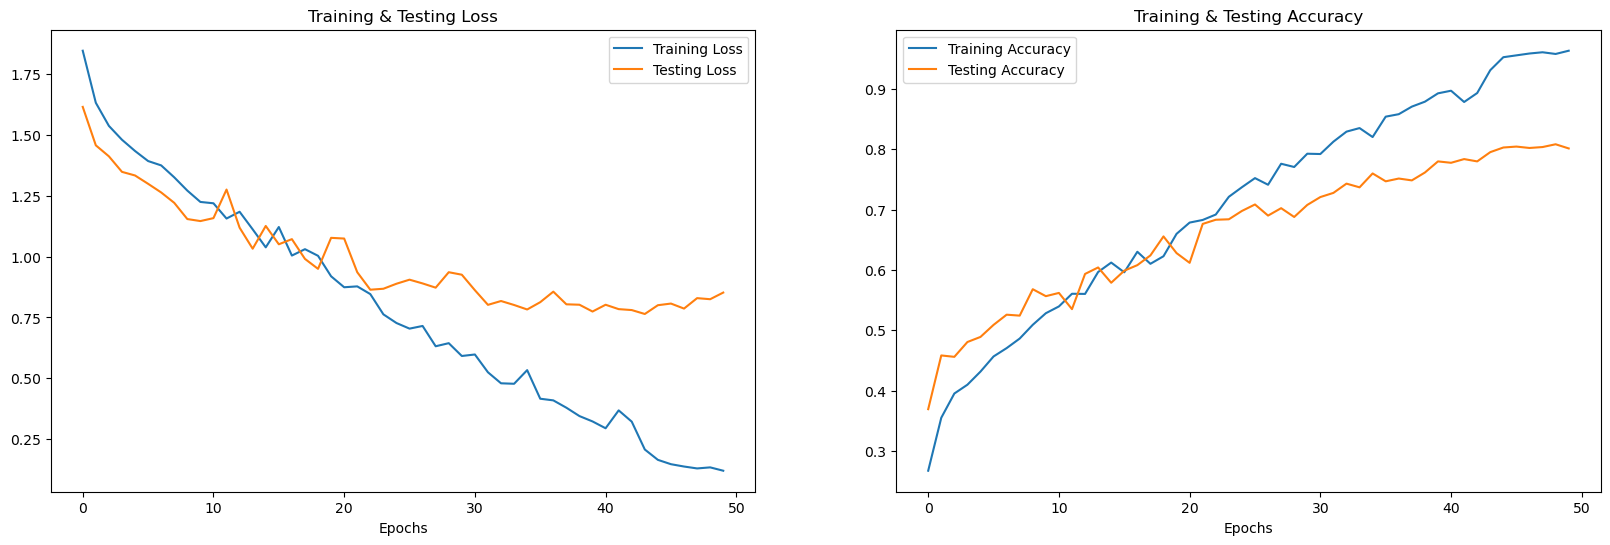

In [88]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [89]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [90]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0         surprise       disgust
1            angry         angry
2              sad           sad
3            happy         happy
4             fear          fear
5            angry         angry
6            angry         angry
7            angry         angry
8          disgust       disgust
9              sad          fear

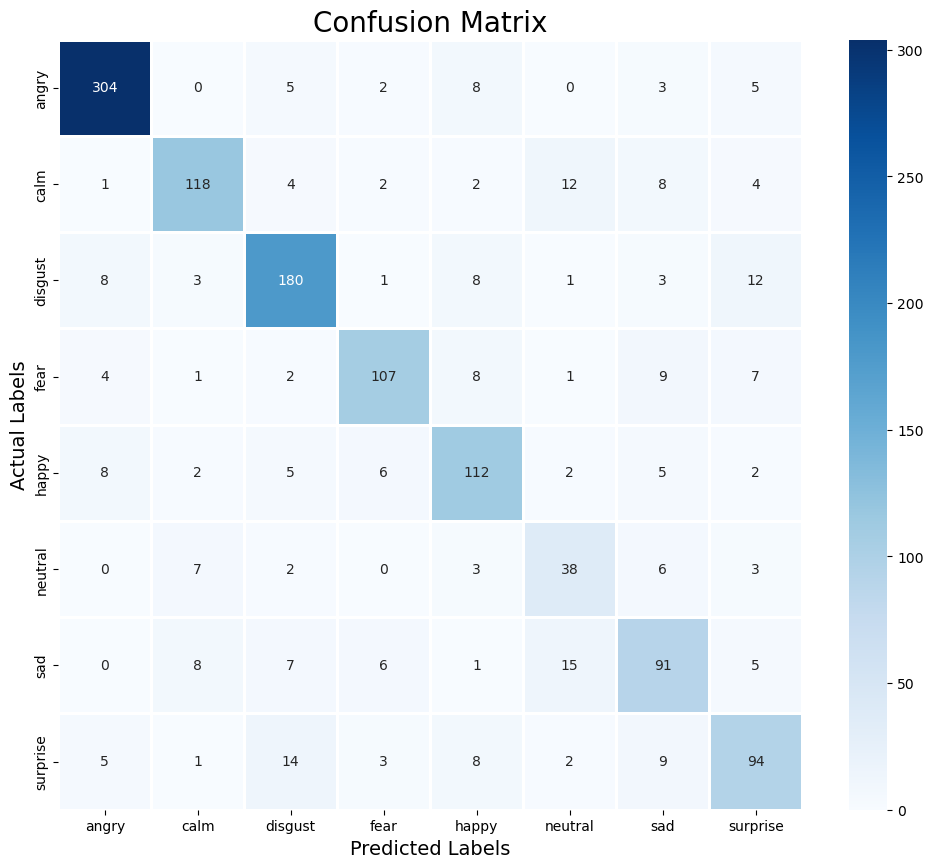

In [91]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [92]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.93      0.93       327
        calm       0.84      0.78      0.81       151
     disgust       0.82      0.83      0.83       216
        fear       0.84      0.77      0.80       139
       happy       0.75      0.79      0.77       142
     neutral       0.54      0.64      0.58        59
         sad       0.68      0.68      0.68       133
    surprise       0.71      0.69      0.70       136

    accuracy                           0.80      1303
   macro avg       0.76      0.77      0.76      1303
weighted avg       0.80      0.80      0.80      1303

